# Convergence of Stochastic Approximation Step-Sizes

This notebook explores why sequences of step-size parameters $\{\alpha_n\}$ 
converge (or fail to converge) under the Robbins–Monro conditions:
  1. $\sum_{n=1}^\infty \alpha_n = \infty$
  2. $\sum_{n=1}^\infty \alpha_n^2 < \infty$

We will:
- Visualize different $\alpha_n$ schedules
- Plot their cumulative sums and squared sums to see which conditions hold
- Simulate the update $Q_{n+1}=Q_n+\alpha_n(X_n-Q_n)$ to see convergence behavior

## Understanding the Robbins–Monro Conditions

The Robbins-Monro update rule is  

$$Q_{n+1} \;=\; Q_n \;+\; \alpha_n (X_n - Q_n) $$

where $X_n$ is a noisy observation of the true mean $\mu$ and $\alpha_n$ is the step-size.

Robbins-Monro guarantees almost-sure convergence when the step-sizes satisfy  

$$
\sum_{n=1}^{\infty} \alpha_n = \infty
\quad\text{and}\quad
\sum_{n=1}^{\infty} \alpha_n^{\,2} < \infty.
$$

---

#### 1.  Why must $\displaystyle \sum_{n=1}^{\infty}\alpha_n = \infty$?

* The total “movement budget’’ of the algorithm is  
  $\sum_{n}\alpha_n$.  
* If this sum were finite, the estimate would **freeze** after a while and could never fully correct large initial errors or early noise.  
* Requiring the sum to diverge ensures unlimited capacity to keep adjusting toward the truth.

---

#### 2.  Why must $\displaystyle \sum_{n=1}^{\infty}\alpha_n^{\,2} < \infty$?

Assume $X_n = \mu + \varepsilon_n$ with $\mathbb{E}[\varepsilon_n]=0$ and $\operatorname{Var}(\varepsilon_n)=\sigma^2$.

Near convergence ($Q_n \approx \mu$) the update is  
$$
Q_{n+1} \approx \mu \;+\; \alpha_n\varepsilon_n .
$$

* Each step adds noise with variance $\alpha_n^{\,2}\sigma^2$.  
* The total variance accumulated over the run is  
  $\sigma^2\sum_{n}\alpha_n^{\,2}$.  
* To **stabilize** the estimate, that variance must be finite, hence the squared-sum condition.

---

### Key Takeaways

* **Condition 1** $\bigl(\sum \alpha_n = \infty\bigr)$: prevents premature freezing, guarantees the algorithm can always keep learning.  
* **Condition 2** $\bigl(\sum \alpha_n^{\,2} < \infty\bigr)$: prevents infinite noise accumulation, letting the estimate settle.

A classic schedule that meets both requirements is  

$$
{\alpha_n = \tfrac{1}{n}}
$$

(where more generally any power-law $\alpha_n = 1/n^{p}$ with $0.5 < p \le 1$ also works).


In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 1. Define Step-Size Sequences
We compare:
- Constant:          $\alpha_n=0.1$
- Harmonic:          $\alpha_n=1/n$                  (p=1)
- Subharmonic slow:  $\alpha_n=1/n^{0.75}$           (0.5<p<1)
- Subharmonic fast:  $\alpha_n=1/n^{1.25}$           (p>1)

In [22]:
N = 100000
n = np.arange(1, N+1)
schedules = {
    'constant α=0.1'     : np.full(N, 0.1),
    '1/n^0.25 (p=0.25)'   : 1.0/(n**0.25),
    '1/n^0.75 (p=0.75)'   : 1.0/(n**0.75),
    '1/n (p=1.0)'         : 1.0/n,
    '1/n^1.25 (p=1.25)'   : 1.0/(n**1.25),
}

### Plot the Step-Size Sequences

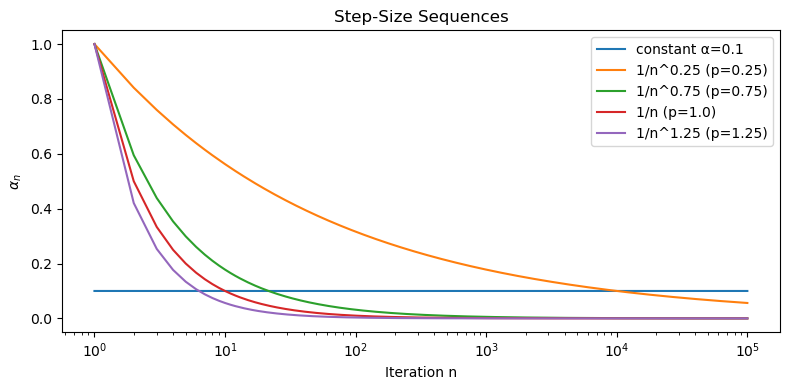

In [29]:
plt.figure(figsize=(8, 4))
for name, alpha in schedules.items():
    plt.plot(n, alpha, label=name)
plt.title('Step-Size Sequences')
plt.xlabel('Iteration n')
plt.ylabel(r'$\alpha_n$')
plt.xscale('log')
plt.legend()
plt.tight_layout()
plt.show()

## 2. Check Convergence Conditions
Compute partial sums:
$$
   S_1(n)=\sum_{i=1}^n\alpha_i,
   \quad
   S_2(n)=\sum_{i=1}^n\alpha_i^2
$$

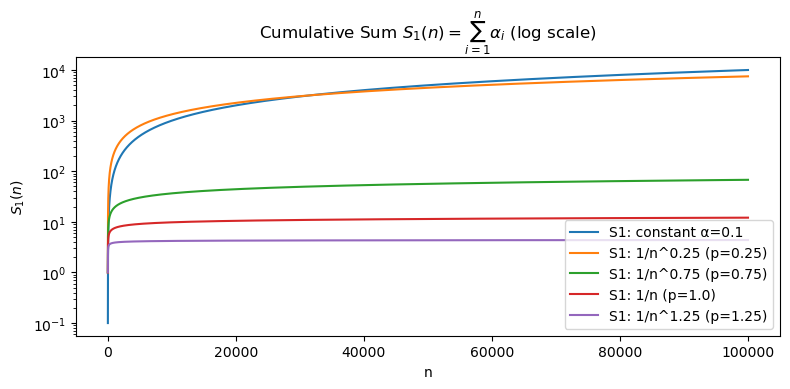

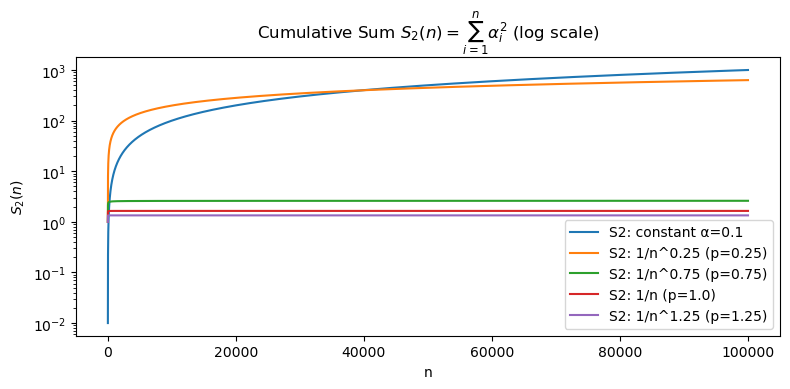

In [24]:
plt.figure(figsize=(8, 4))
for name, alpha in schedules.items():
    S1 = np.cumsum(alpha)
    plt.plot(n, S1, label=f'S1: {name}')
plt.yscale('log')
plt.title(r'Cumulative Sum $S_1(n)=\sum_{i=1}^n\alpha_i$ (log scale)')
plt.xlabel('n')
plt.ylabel(r'$S_1(n)$')
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(8, 4))
for name, alpha in schedules.items():
    S2 = np.cumsum(alpha**2)
    plt.plot(n, S2, label=f'S2: {name}')
plt.yscale('log')
plt.title(r'Cumulative Sum $S_2(n)=\sum_{i=1}^n\alpha_i^2$ (log scale)')
plt.xlabel('n')
plt.ylabel(r'$S_2(n)$')
plt.legend(); plt.tight_layout(); plt.show()

# Interpretation
- If S1 grows without bound (diverges) then condition 1 is met.
- If S2 converges to a finite limit, then condition 2 is met.

From the plots you should observe:
- $0.1$ and $1/n^{0.75}$: fails because diverge on S2
- $1/n^{0.25}$: fails because converge on S2
- $1/n$ : (harmonic series) feels like converge on S1, but it doesn't 

## 3. Simulate the Update Rule
We simulate a single sequence of i.i.d. samples $X_n\sim\mathcal{N}(1,1)$ and update
$Q_{n+1} = Q_n + \alpha_n (X_n - Q_n)$.

In [25]:
true_mean = 1.0
Q_hist = {name: np.zeros(N) for name in schedules}
for name, alpha in schedules.items():
    Q = 0.0
    for i in range(N):
        x = true_mean + np.random.randn()
        Q += alpha[i] * (x - Q)
        Q_hist[name][i] = Q

Plot the trajectory of $Q_n$ for each schedule

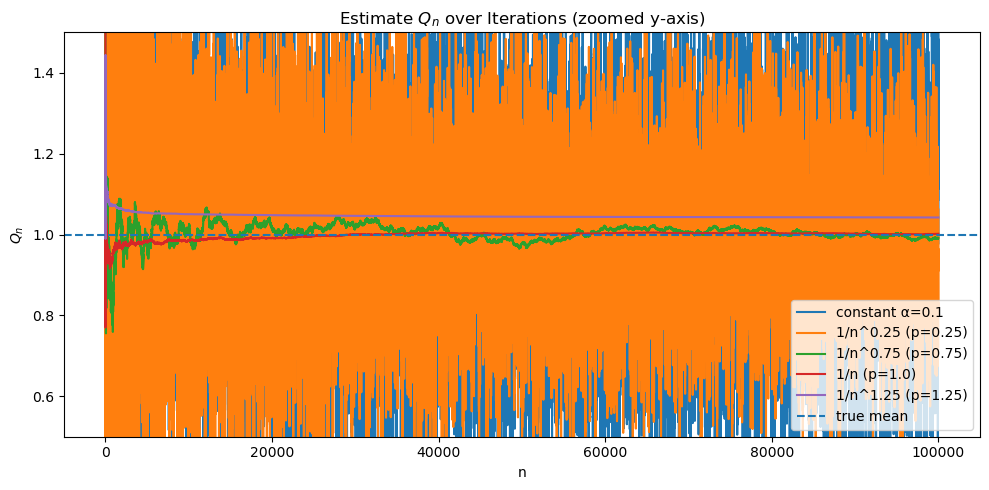

In [27]:
plt.figure(figsize=(10, 5))
for name, Qvals in Q_hist.items():
    plt.plot(n, Qvals, label=name)
plt.axhline(true_mean, linestyle='--', label='true mean')
plt.title('Estimate $Q_n$ over Iterations (zoomed y-axis)')
plt.xlabel('n')
plt.ylabel(r'$Q_n$')
plt.ylim(0.5, 1.5)  # zoom in around the true mean
plt.legend()
plt.tight_layout()
plt.show()



# Conclusion:

- Only the learning rate $\alpha_n = \frac{1}{n}$ (and others with expoent $0.5 < p < 1$) satisfies both Robbins–Monro conditions:
  $$
  \sum_{n=1}^{\infty} \alpha_n = \infty \quad \text{e} \quad \sum_{n=1}^{\infty} \alpha_n^2 < \infty
  $$
  This ensures that $Q_n$ converge to the true average mean with decreasing variance.

- Constant values of $\alpha$, or rates that decay too quickly (e.g., $p < 0.5$) or too fast (e.g., $p > 1$), lead to unstable or biased estimates. In particular:
  - **Too slow steps:** high variance and continuous oscilations.
  - **Too fast steps:** the algorithm converge to the wrong value (don't learn anymore).



## Exercise 2.4  
If the step-size parameters $\alpha_n$ vary with $n$, then the estimate $Q_n$ becomes a weighted average of past rewards with non-uniform weights. Derive an explicit expression for the weight placed on each past reward $R_i$ $(i \le n)$ in terms of the sequence $\{\alpha_k\}_{k=1}^n$, analogous to the *incremental average equation* below:

$$
\begin{aligned}
Q_{n+1}
  &= Q_n + \alpha\,[\,R_n - Q_n\,] \\[4pt]
  &= \alpha R_n + (1-\alpha)Q_n \\[6pt]
  &= \alpha R_n + (1-\alpha)\bigl[\alpha R_{n-1} + (1-\alpha)Q_{n-1}\bigr] \\[6pt]
  &= \alpha R_n + (1-\alpha)\alpha R_{n-1} + (1-\alpha)^2 Q_{n-1} \\[6pt]
  &\;\;\vdots \\[6pt]
  &= (1-\alpha)^n Q_1
     \;+\;
     \sum_{i=1}^{n}\alpha (1-\alpha)^{\,n-i}\,R_i .
\end{aligned}
$$

Thus, for a constant $\alpha$, the weight on reward $R_i$ is
$$
w_i^{(n)} \;=\;
\alpha\,(1-\alpha)^{\,n-i},
\qquad
i = 1,\dots,n.
$$

#### Answer

For arbitrary step sizes $\{\alpha_n\}$, start from the incremental update

$$
Q_{n+1} \;=\; Q_n + \alpha_n \bigl(R_n - Q_n\bigr),
$$

and unroll it recursively:

$$
\begin{aligned}
Q_{n+1}
&= (1-\alpha_n)Q_n + \alpha_n R_n \\[4pt]
&= (1-\alpha_n)\!\bigl[(1-\alpha_{n-1})Q_{n-1} + \alpha_{n-1}R_{n-1}\bigr] + \alpha_n R_n \\[4pt]
&=\;\cdots \\[4pt]
&= \Bigl[\prod_{k=1}^{n}(1-\alpha_k)\Bigr] Q_0
    \;+\; \sum_{i=1}^{n} \Bigl[\alpha_i\,\prod_{k=i+1}^{\,n}(1-\alpha_k)\Bigr] R_i .
\end{aligned}
$$

Hence **the weight on the $i$-th reward** ($1\le i\le n$) is

$$
\,w_i^{(n)} \;=\; 
\alpha_i \!\!\!\!\prod_{k=i+1}^{\,n}\!\! (1-\alpha_k)\,
$$

and all weights sum to one:

$$
\sum_{i=1}^{n} w_i^{(n)} \;+\;\prod_{k=1}^{n}(1-\alpha_k)\;=\;1.
$$

**What does it mean?** Take the initial injection of $R_i$ and keep discounting it by every later $1−\alpha_k$; whatever is left at time $n$ is its weight in the estimate.

If the product decays fast (large $\alpha_k$), old rewards are quickly forgotten, maybe good for *non-stationary* problems.

---




## Exercise 2.5 (programming)  
Design and conduct an experiment showing how sample-average methods struggle on *non-stationary* problems.

* **Environment:** a modified 10-armed testbed in which every true action value $q^*_a$ starts equal and then follows an independent random walk: on each step add $\mathcal N(0,0.01^2)$ to every $q^*_a$.
* **Agents:**  
  1. **Sample-average** action-value method (incremental average).  
  2. **Constant step-size** action-value method with $\alpha = 0.1$.
* **Common settings:** $\varepsilon = 0.1$; run length 10 000 steps; e.g., 2 000 independent runs.  
* **Output:** plots analogous to Figure 2.2 (average reward and % optimal action versus steps).

Compare and discuss the two methods.

In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
def nonstationary_bandit(k=10, walksigma=0.01):
    """
         Return callable: step(a) : (reward, current_opt_arm)
    """
    q_star = np.zeros(k)              # all q* start equal at zero
    def step(a):
        nonlocal q_star
        reward = q_star[a] + np.random.randn() # N(q*, 1)
        q_star += np.random.normal(0, walksigma, size=k)  # random walk
        return reward, np.argmax(q_star)
    return step

In [7]:
def run_agent(alpha_mode, runs=100, steps=10000, k=10, eps=0.1):
    rewards = np.zeros(steps)
    optimal  = np.zeros(steps)
    for _ in range(runs):
        env = nonstationary_bandit(k)
        Q   = np.zeros(k)
        N   = np.zeros(k)          # counts for sample-average
        for t in range(steps):
            a = np.random.randint(k) if np.random.rand() < eps else np.argmax(Q)
            r, best = env(a)
            alpha = 1.0 / (N[a] + 1) if alpha_mode == 'sample' else 0.1
            N[a] += 1
            Q[a] += alpha * (r - Q[a])
            rewards[t] += r
            optimal[t] += (a == best)
    return rewards / runs, optimal / runs * 100

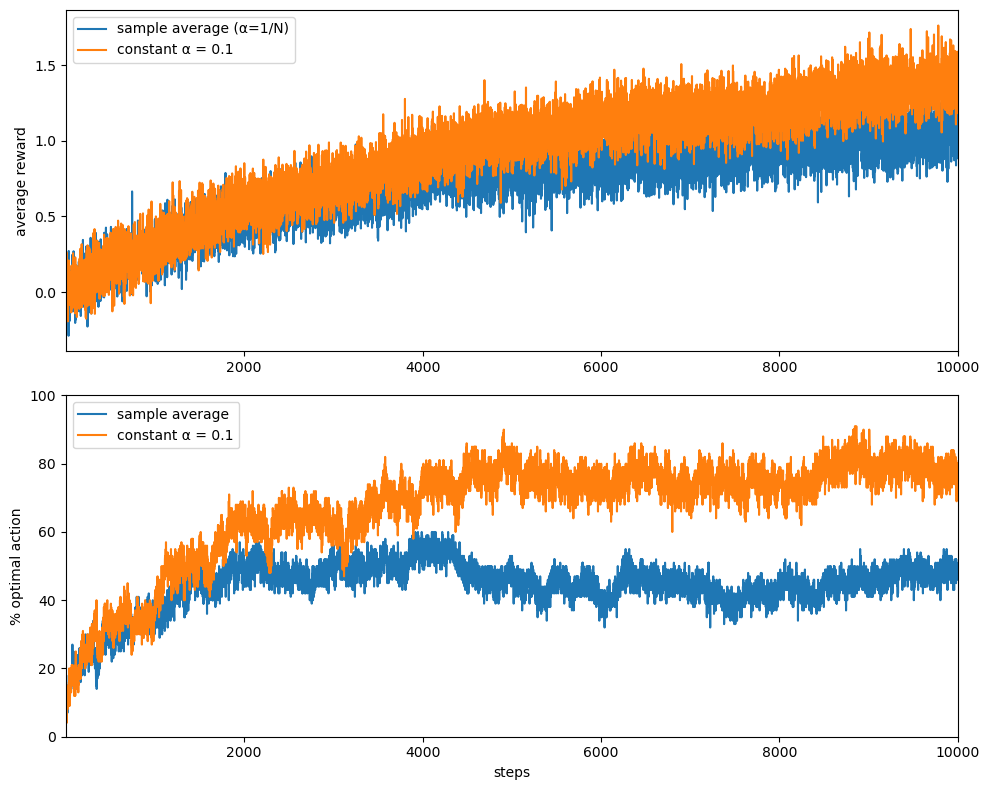

In [8]:
sample_r, sample_opt = run_agent('sample')
const_r , const_opt  = run_agent('const')

steps = np.arange(1, len(sample_r)+1)
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.plot(steps, sample_r, label='sample average (α=1/N)')
plt.plot(steps, const_r , label='constant α = 0.1')
plt.ylabel('average reward'); plt.xlim(1, steps[-1]); plt.legend()

plt.subplot(2,1,2)
plt.plot(steps, sample_opt, label='sample average')
plt.plot(steps, const_opt , label='constant α = 0.1')
plt.xlabel('steps'); plt.ylabel('% optimal action')
plt.xlim(1, steps[-1]); plt.ylim(0,100); plt.legend()
plt.tight_layout(); plt.show()